In [1]:
import torch
import functorch

from sngrok.permutations import Permutation, make_permutation_dataset
from sngrok.model import SnMLP
from sngrok.tableau import generate_partitions
from sngrok.irreps import SnIrrep

In [2]:
run = torch.load('checkpoints/s5_50_02/full_run.pth', map_location=torch.device('cpu'))

In [3]:
run['config']

{'embed_dim': 256, 'model_dim': 128, 'vocab_size': 120, 'tie_lr': False}

In [39]:

def _dot(fx, rho):
    return fx * rho

fft_dot = functorch.vmap(scalar_x_mat, in_dims=(0, 0))

def _fft_sum(fx, rho):
    if rho.dim() == 1:
        return torch.dot(fx, rho)
    else:
        return fft_dot(fx, rho).sum(dim=0)
    
fft_sum = functorch.vmap(_fft_sum, in_dims=(1, None))




In [38]:
list(run.keys())

['model', 'config', 'checkpoints', 'checkpoint_epochs']

In [6]:
model = SnMLP.from_config(run['config'])
model.load_state_dict(run['model'])

<All keys matched successfully>

In [7]:
total = 0
for params in model.parameters():
    total += params.numel()
total

142456

In [40]:

def slow_ft(fn_vals, n):
    all_partitions = generate_partitions(n)
    permutations = Permutation.full_group(n)
    #fn_vals = fn(permutations)
    all_irreps = [SnIrrep(n, p) for p in all_partitions]
    results = {}
    for irrep in all_irreps:
        matrices = irrep.matrix_tensor()
        results[irrep.shape] = fft_sum(fn_vals, matrices).squeeze()
    return results

fn0 = model.lembed.weight[:, 0:4]

fourier0 = slow_ft(fn0, 5)

In [45]:
fourier0[(3,1, 1)].shape

torch.Size([4, 6, 6])

In [75]:
lembed = model.lembed.weight

ft_lembed = slow_ft(lembed, 5)
fourier_basis = 


In [70]:
fourier0[(1, 1, 1, 1, 1)][0]

tensor(-0.1569, dtype=torch.float64, grad_fn=<SelectBackward0>)

In [76]:
ft_decomp = sn_fourier_basis(fourier0, 5)

In [77]:
ft_decomp.shape

torch.Size([120, 7, 4])

In [34]:
ft_decomp[5]

tensor([-0.0013, -0.0086, -0.0061, -0.0001,  0.0020,  0.0049, -0.0553],
       grad_fn=<SelectBackward0>)

In [28]:
out, cache = model.run_with_cache(torch.tensor(0), torch.tensor(0))

In [10]:
x, y = torch.cartesian_prod(torch.arange(0, 120), torch.arange(0, 120)).hsplit(2)
x, y = x.squeeze(), y.squeeze()
out, cache = model.run_with_cache(x, y)

In [11]:
out.shape

torch.Size([14400, 120])

In [12]:
labels = torch.argmax(out, dim=1)

In [13]:
inverse_idx = torch.where(labels == 0)[0]

In [14]:
list(cache.keys())

['hook_lembed', 'hook_rembed', 'hook_linear', 'hook_unembed']

In [68]:
from torch.nn.functional import relu

ident_linear = relu(cache['hook_linear'][inverse_idx])
ident_logits = out[inverse_idx]

In [58]:
ident

True

In [17]:
import pandas as pd

In [60]:
linear_df = pd.DataFrame(ident_linear.numpy())
linear_df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.002089,0.000000,0.000715,2.876616,0.000000,0.000229,4.150613,0.000000,0.000054,0.000047,...,0.000000,0.000000,1.047771,3.555363,1.528522,0.000000,0.000000,3.368933,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.012944,0.000000,0.000000,5.994815,0.000663,0.001536,...,2.696643,0.482357,0.000000,0.000000,1.529670,3.546854,0.379890,3.368501,1.020660,2.876663
2,0.003523,0.000000,0.000402,0.000000,0.000000,0.000065,1.536906,0.000000,0.000000,0.000246,...,0.000000,1.107533,0.000000,0.000000,4.125823,0.000000,0.868271,6.039986,0.000000,0.000000
3,0.000000,0.000573,0.000669,1.721225,0.001140,0.000000,0.000000,0.000000,0.000000,0.000283,...,0.000000,8.248049,0.000000,0.000000,4.090522,5.082184,6.459482,6.002008,0.000000,0.000000
4,0.000000,0.000000,0.000225,3.304460,0.000000,0.002392,1.536308,3.413246,0.000625,0.000282,...,9.044312,0.000000,0.457242,8.376721,0.000000,6.231646,0.000000,0.000000,0.879884,6.553003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.000000,0.001741,0.002998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.813801,3.891953,0.000000,4.483898,0.000000,0.000000,3.047458,2.922374,0.601181,0.000000
116,0.000000,0.000000,0.000000,0.000000,0.011160,0.000000,0.000000,2.170182,0.000000,0.000000,...,1.585873,2.425977,0.000000,0.000000,0.000000,3.390967,1.896817,4.720777,1.023755,0.543902
117,0.004201,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.126791,0.004153,0.000000,...,0.000000,2.556505,0.000000,2.090256,0.000000,0.000000,2.003340,4.720829,1.095226,0.000000
118,0.000000,0.000882,0.000000,3.608049,0.027663,0.001352,0.000000,0.000000,0.000239,0.000151,...,0.000000,0.000000,3.678776,0.000000,0.000000,0.000000,0.000000,6.294633,0.864256,1.245561


In [70]:
model.unembed.weight @ ident_linear[1, :]

tensor([40.1680,  4.1649, 17.6281,  8.9234, 12.2664, 16.3138, 19.9752, 20.5555,
        17.0140,  4.7080, 15.0376, 19.1882, 17.1998, 14.6809, 14.3504, 14.2262,
        17.9017, 15.0964,  7.1888, 23.4826, 17.0538, 20.6070, 12.0992, 10.6593,
        24.4055, 11.4540, 19.2921,  4.4583,  2.2153, 22.9052, 23.3848,  5.4080,
        14.7161,  3.8250, 17.1308, 18.8079, 11.6928, 15.1204, 20.8457,  6.3045,
        11.2234, 11.6823, 12.1434, 11.8954, 18.2578, 17.5687, 14.5531,  4.7022,
        22.1206,  6.3160,  8.1474,  7.5877, 14.7745, 18.8598, 18.6239,  6.6648,
        16.5482,  8.5767, 15.1027, 16.5259, 20.3565,  3.8284, 24.7058,  4.4595,
        11.0971,  5.2817,  7.5648, 20.0876, 11.1306, 14.1842,  6.9312,  7.0536,
        16.6404, 10.4555, 25.2127, 12.2404,  9.6439, 13.1589, 11.3169,  8.3722,
        15.2657, 17.2328, 23.8807, 10.3180, 20.7736, 11.5840, 24.0659,  1.5724,
        12.1428,  8.6762, 17.7761,  7.7713, 15.7814, 15.8559, 17.5567,  7.6456,
        13.2580, 19.7361,  9.1853, 15.90

In [71]:
ident_logits[1, :]

tensor([40.1715,  4.0805, 17.6060,  8.9567, 12.2844, 16.3225, 19.9671, 20.6148,
        17.0111,  4.7052, 15.0050, 19.1224, 17.2122, 14.6394, 14.3533, 14.2605,
        17.9291, 15.0975,  7.1519, 23.4838, 17.0868, 20.5803, 12.0705, 10.6966,
        24.3643, 11.4381, 19.3316,  4.4702,  2.1738, 22.9115, 23.4262,  5.3991,
        14.6678,  3.8380, 17.1409, 18.7685, 11.6520, 15.0945, 20.8899,  6.3152,
        11.2230, 11.7178, 12.1557, 11.8686, 18.2425, 17.5528, 14.5628,  4.6983,
        22.1086,  6.2854,  8.1337,  7.5489, 14.8003, 18.8460, 18.5626,  6.6595,
        16.6019,  8.5459, 15.0584, 16.5356, 20.3679,  3.8146, 24.6740,  4.5053,
        11.0944,  5.2614,  7.4835, 20.1170, 11.1465, 14.1330,  6.9131,  7.0736,
        16.6582, 10.4881, 25.2305, 12.2563,  9.5960, 13.1805, 11.3402,  8.3848,
        15.2597, 17.2774, 23.9022, 10.3036, 20.7765, 11.5998, 24.0760,  1.5225,
        12.1765,  8.7282, 17.8148,  7.7492, 15.7990, 15.8958, 17.5582,  7.6608,
        13.2764, 19.7208,  9.1858, 15.94

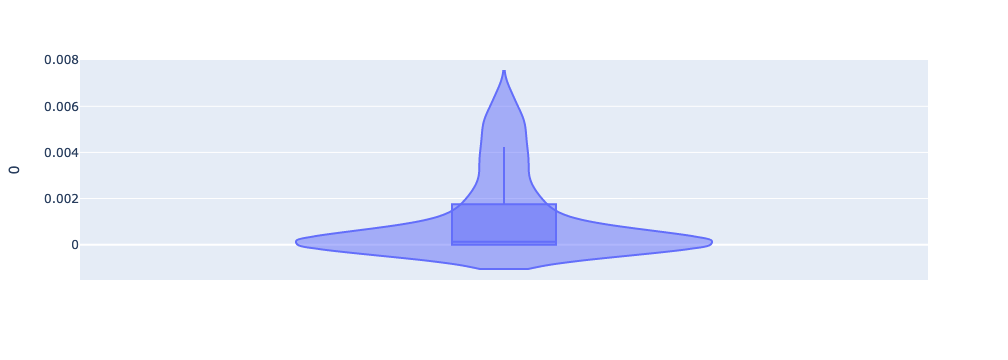

In [62]:
import plotly.express as px

fig = px.violin(linear_df, y=0, box=True, # draw box plot inside the violin
                points=False, # can be 'outliers', or False
               )
fig.show()

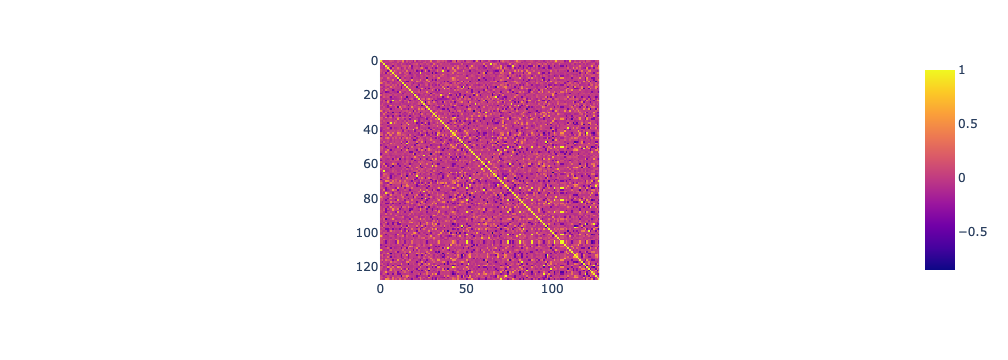

In [63]:
linear_corr = linear_df.corr()
fig = px.imshow(linear_corr)
fig.show()

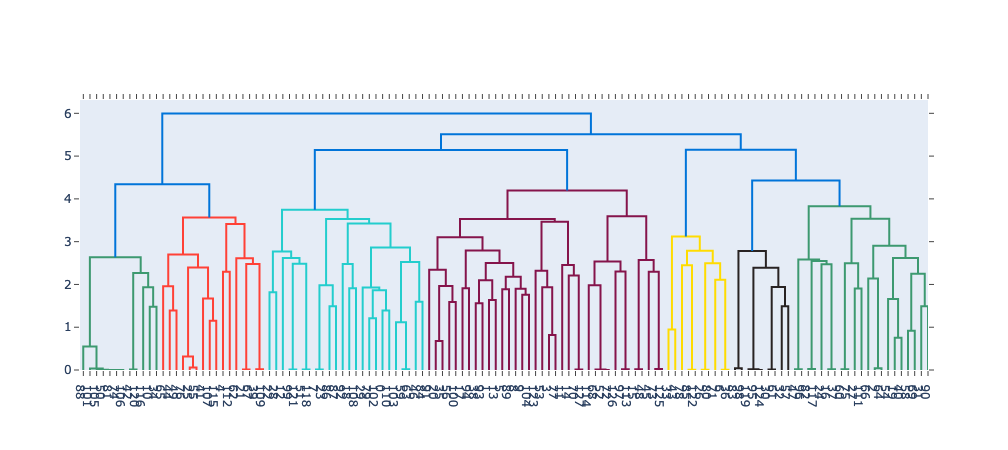

In [64]:
from plotly.figure_factory import create_dendrogram
labels = list(range(128))
dendro = create_dendrogram(linear_corr, labels = labels)
dendro.show()

In [46]:
s1 = lembed[1, :]
s2 = lembed[2, :]

In [48]:
torch.dot(s1, s1)

tensor(8.1146, grad_fn=<DotBackward0>)

In [49]:
s1.reshape((16, 16))

tensor([[-0.0798, -0.0960,  0.1077,  0.0325, -0.0825,  0.1536,  0.1722,  0.1597,
         -0.0734,  0.0152, -0.0396,  0.2561, -0.2368, -0.0884, -0.0655,  0.2594],
        [ 0.0043,  0.1241,  0.0332, -0.2043,  0.1219,  0.0890,  0.1349, -0.1033,
         -0.0418, -0.2410,  0.1115, -0.1737, -0.0058, -0.2867, -0.3058,  0.0345],
        [-0.1777, -0.2892,  0.1486, -0.0630,  0.2491, -0.2442, -0.1335, -0.0793,
         -0.2375, -0.0046,  0.3254, -0.1694,  0.3091,  0.2435, -0.2591, -0.2787],
        [ 0.3023,  0.1994,  0.0481, -0.0181,  0.2450, -0.2293, -0.0749, -0.0588,
         -0.1108,  0.0897,  0.0925,  0.2251,  0.2805, -0.1811, -0.1187,  0.0966],
        [ 0.0196,  0.0454, -0.2858,  0.0072,  0.0538, -0.0275,  0.1597, -0.2080,
         -0.1045, -0.1182, -0.1884, -0.2935, -0.1406, -0.2505, -0.3356,  0.0497],
        [-0.1343,  0.0516,  0.1694,  0.3633, -0.0699,  0.0614,  0.1990, -0.0988,
         -0.2295, -0.0517, -0.2264,  0.2857,  0.2142, -0.1709, -0.0353, -0.2892],
        [ 0.1312, -0.0